# [New York City Taxi Trip Duration - Kaggle](https://www.kaggle.com/c/nyc-taxi-trip-duration/kernels)

### Data fields
* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* trip_duration - duration of the trip in seconds

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

import datetime as dt

import xgboost as xgb
from sklearn.model_selection import train_test_split

# 노트북 안에 그래프가 표시되도록
%matplotlib inline

# 한글폰트 사용 시 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
plt.rcParams['axes.unicode_minus'] = False

In [2]:
t0 = dt.datetime.now()
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print(train.shape)
print(test.shape)

(1458644, 11)
(625134, 9)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null object
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB


In [5]:
train.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


In [6]:
test.head(3)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N


#### parse datetime

In [7]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')

In [8]:
train['check_trip_duration'] = (
    train['dropoff_datetime'] - train['pickup_datetime']
).map(lambda x: x.total_seconds())
duration_difference = train[np.abs(train['check_trip_duration'].values  - train['trip_duration'].values) > 1]
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

Trip_duration and datetimes are ok.


In [9]:
train['trip_duration'].max() // 3600

979

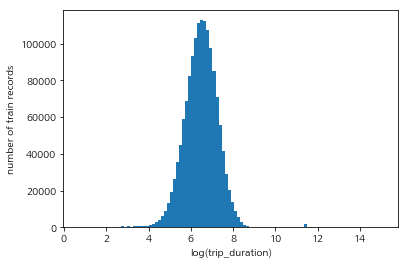

In [10]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

#### Validation Strategy

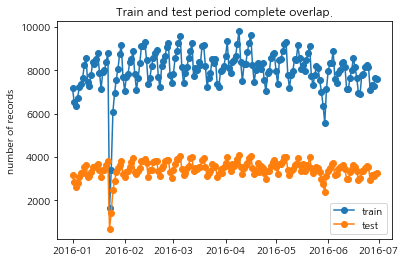

In [11]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Train and test period complete overlap.')
plt.legend(loc=0)
plt.ylabel('number of records')
plt.show()

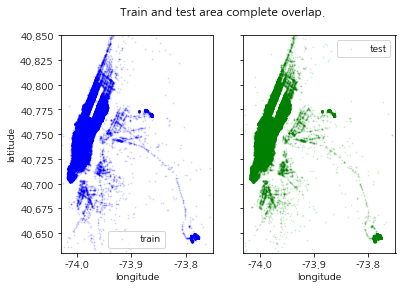

In [12]:
N = 100000 # number of sample rows in plots
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:N], 
              train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:N], 
              test['pickup_latitude'].values[:N],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

### Feature Extraction
#### PCA

In [13]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(
    train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(
    train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(
    train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(
    train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

test['pickup_pca0'] = pca.transform(
    test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(
    test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(
    test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(
    test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

In [14]:
print(train.shape)
print(test.shape)

(1458644, 18)
(625134, 14)


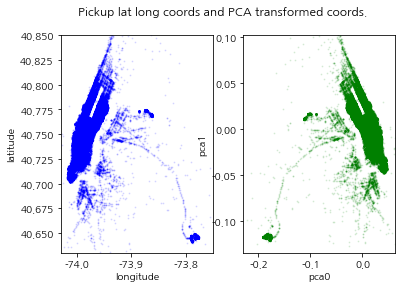

In [15]:
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, alpha=0.1)
ax[1].scatter(train['pickup_pca0'].values[:N], train['pickup_pca1'].values[:N],
              color='green', s=1, alpha=0.1)
fig.suptitle('Pickup lat long coords and PCA transformed coords.')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('pca0')
ax[1].set_ylabel('pca1')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders = pca.transform([[x, y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
ax[1].set_ylim(pca_borders[:, 1].min(), pca_borders[:, 1].max())
plt.show()

#### Distance

In [16]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [17]:
train.loc[:, 'distance_haversine'] = haversine_array(
    train['pickup_latitude'].values, 
    train['pickup_longitude'].values, 
    train['dropoff_latitude'].values, 
    train['dropoff_longitude'].values)
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(
    train['pickup_latitude'].values, 
    train['pickup_longitude'].values, 
    train['dropoff_latitude'].values, 
    train['dropoff_longitude'].values)
train.loc[:, 'direction'] = bearing_array(
    train['pickup_latitude'].values, 
    train['pickup_longitude'].values, 
    train['dropoff_latitude'].values, 
    train['dropoff_longitude'].values)
train.loc[:, 'pca_manhattan'] = np.abs(
    train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(
    train['dropoff_pca0'] - train['pickup_pca0'])

In [18]:
train.shape

(1458644, 22)

In [19]:
test.loc[:, 'distance_haversine'] = haversine_array(
    test['pickup_latitude'].values, 
    test['pickup_longitude'].values, 
    test['dropoff_latitude'].values, 
    test['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(
    test['pickup_latitude'].values, 
    test['pickup_longitude'].values, 
    test['dropoff_latitude'].values, 
    test['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(
    test['pickup_latitude'].values, 
    test['pickup_longitude'].values, 
    test['dropoff_latitude'].values, 
    test['dropoff_longitude'].values)
test.loc[:, 'pca_manhattan'] = np.abs(
    test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(
    test['dropoff_pca0'] - test['pickup_pca0'])

In [20]:
test.shape

(625134, 18)

In [21]:
train.loc[:, 'center_latitude'] = (
    train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (
    train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test.loc[:, 'center_latitude'] = (
    test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (
    test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

In [22]:
print(train.shape)
print(test.shape)

(1458644, 24)
(625134, 20)


#### Datetime features

In [23]:
train.loc[:, 'pickup_weekday'] = train['pickup_datetime'].dt.weekday
train.loc[:, 'pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train.loc[:, 'pickup_hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'pickup_minute'] = train['pickup_datetime'].dt.minute
train.loc[:, 'pickup_dt'] = (
    train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test.loc[:, 'pickup_weekday'] = test['pickup_datetime'].dt.weekday
test.loc[:, 'pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test.loc[:, 'pickup_hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'pickup_minute'] = test['pickup_datetime'].dt.minute
test.loc[:, 'pickup_dt'] = (
    test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

In [24]:
print(train.shape)
print(test.shape)

(1458644, 30)
(625134, 26)


#### Speed

In [25]:
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']

In [26]:
print(train.shape)
print(test.shape)

(1458644, 32)
(625134, 26)


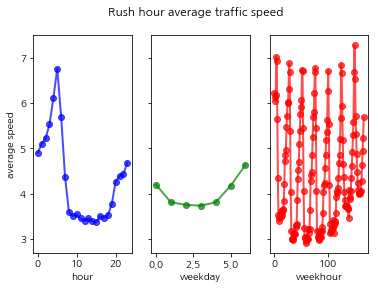

In [27]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('pickup_week_hour').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('weekhour')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

In [28]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]

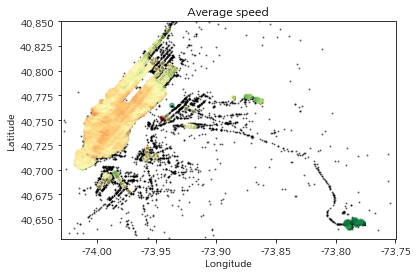

In [29]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N],
           color='black', s=1, alpha=0.5)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values,
           c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()

In [30]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 2)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 2)
train.loc[:, 'center_lat_bin'] = np.round(train['center_latitude'], 2)
train.loc[:, 'center_long_bin'] = np.round(train['center_longitude'], 2)
train.loc[:, 'pickup_dt_bin'] = (train['pickup_dt'] // (3 * 3600))
test.loc[:, 'pickup_lat_bin'] = np.round(test['pickup_latitude'], 2)
test.loc[:, 'pickup_long_bin'] = np.round(test['pickup_longitude'], 2)
test.loc[:, 'center_lat_bin'] = np.round(test['center_latitude'], 2)
test.loc[:, 'center_long_bin'] = np.round(test['center_longitude'], 2)
test.loc[:, 'pickup_dt_bin'] = (test['pickup_dt'] // (3 * 3600))

In [31]:
print(train.shape)
print(test.shape)

(1458644, 37)
(625134, 31)


#### Clustering

In [32]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [33]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(
    train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(
    train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(
    test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(
    test[['dropoff_latitude', 'dropoff_longitude']])
t1 = dt.datetime.now()
print('Time till clustering: %i seconds' % (t1 - t0).seconds)

Time till clustering: 73 seconds


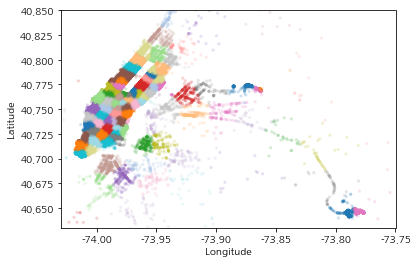

In [34]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N], 
           train.pickup_latitude.values[:N], 
           s=10, lw=0,
           c=train.pickup_cluster[:N].values, cmap='tab20', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

#### Temporal and geospatial aggregation

In [35]:
for gby_col in ['pickup_hour', 'pickup_date', 'pickup_dt_bin',
               'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster']:
    gby = train.groupby(gby_col).mean()[['avg_speed_h', 'avg_speed_m', 
                                         'log_trip_duration']]
    gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    train = pd.merge(train, gby, how='left', left_on=gby_col, right_index=True)
    test = pd.merge(test, gby, how='left', left_on=gby_col, right_index=True)

In [36]:
for gby_cols in [['center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'pickup_cluster'],  
                 ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
    coord_stats = coord_stats[coord_stats['id'] > 100]
    coord_stats.columns = gby_cols + [
        'avg_speed_h_%s' % '_'.join(gby_cols), 
        'cnt_%s' %  '_'.join(gby_cols)]
    train = pd.merge(train, coord_stats, how='left', on=gby_cols)
    test = pd.merge(test, coord_stats, how='left', on=gby_cols)

In [37]:
group_freq = '60min'
df_all = pd.concat((train, test))[[
    'id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
train.loc[:, 'pickup_datetime_group'] = train['pickup_datetime'].dt.round(group_freq)
test.loc[:, 'pickup_datetime_group'] = test['pickup_datetime'].dt.round(group_freq)

In [38]:
# Count trips over 60min
df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()
df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['id']
train = train.merge(df_counts, on='id', how='left')
test = test.merge(df_counts, on='id', how='left')

In [39]:
# Count how many trips are going to each cluster over time
dropoff_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'dropoff_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('dropoff_cluster').rolling('240min').mean() \
    .drop('dropoff_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={
        'pickup_datetime': 'pickup_datetime_group', 
        'id': 'dropoff_cluster_count'})

train['dropoff_cluster_count'] = train[[
    'pickup_datetime_group', 
    'dropoff_cluster']].merge(dropoff_counts, on=[
    'pickup_datetime_group', 'dropoff_cluster'], how='left')[
    'dropoff_cluster_count'].fillna(0)
test['dropoff_cluster_count'] = test[[
    'pickup_datetime_group', 
    'dropoff_cluster']].merge(dropoff_counts, on=[
    'pickup_datetime_group', 
    'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)

/Users/corazzon/codes/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  


In [40]:
print(train.shape)
print(test.shape)

(1458644, 70)
(625134, 64)


In [41]:
# Count how many trips are going from each cluster over time
df_all = pd.concat((train, test))[[
    'id', 'pickup_datetime', 
    'pickup_cluster', 'dropoff_cluster']]

pickup_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'pickup_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('pickup_cluster').rolling('240min').mean() \
    .drop('pickup_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime') \
    .shift(freq='-120min').reset_index() \
    .rename(columns={
        'pickup_datetime': 'pickup_datetime_group', 
        'id': 'pickup_cluster_count'})

/Users/corazzon/codes/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  


In [42]:
train['pickup_cluster_count'] = train[[
    'pickup_datetime_group', 'pickup_cluster']].merge(
    pickup_counts, 
    on=['pickup_datetime_group', 'pickup_cluster'], 
    how='left')['pickup_cluster_count'].fillna(0)

test['pickup_cluster_count'] = test[[
    'pickup_datetime_group', 'pickup_cluster']].merge(
    pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], 
    how='left')['pickup_cluster_count'].fillna(0)

In [43]:
print(train.shape)
print(test.shape)

(1458644, 71)
(625134, 65)


#### Features Selection

In [44]:
feature_names = list(train.columns)
print(np.setdiff1d(train.columns, test.columns))
do_not_use_for_training = ['id', 'log_trip_duration', 
                           'pickup_datetime', 'dropoff_datetime',
                           'trip_duration', 'check_trip_duration',
                           'pickup_date', 'avg_speed_h', 'avg_speed_m',
                           'pickup_lat_bin', 'pickup_long_bin',
                           'center_lat_bin', 'center_long_bin',
                           'pickup_dt_bin', 'pickup_datetime_group']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]

print(pd.DataFrame(feature_names))
print('Features 갯수 :  %i ' % len(feature_names))
train[feature_names].count()
y = np.log(train['trip_duration'].values + 1)

t1 = dt.datetime.now()
print('Feature 추출 시간: %i seconds' % (t1 - t0).seconds)

['avg_speed_h' 'avg_speed_m' 'check_trip_duration' 'dropoff_datetime'
 'log_trip_duration' 'trip_duration']
                                                    0
0                                           vendor_id
1                                     passenger_count
2                                    pickup_longitude
3                                     pickup_latitude
4                                   dropoff_longitude
5                                    dropoff_latitude
6                                  store_and_fwd_flag
7                                         pickup_pca0
8                                         pickup_pca1
9                                        dropoff_pca0
10                                       dropoff_pca1
11                                 distance_haversine
12                           distance_dummy_manhattan
13                                          direction
14                                      pca_manhattan
15                          

In [45]:
print(train.shape)
print(test.shape)

(1458644, 71)
(625134, 65)


In [46]:
feature_stats = pd.DataFrame({'feature': feature_names})
feature_stats.loc[:, 'train_mean'] = np.nanmean(
    train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_mean'] = np.nanmean(
    test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_std'] = np.nanstd(
    train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_std'] = np.nanstd(
    test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_nan'] = np.mean(
    np.isnan(train[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'test_nan'] = np.mean(
    np.isnan(test[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'train_test_mean_diff'] = np.abs(
    feature_stats['train_mean'] - feature_stats['test_mean']) / np.abs(feature_stats['train_std'] + feature_stats['test_std'])  * 2
feature_stats.loc[:, 'train_test_nan_diff'] = np.abs(
    feature_stats['train_nan'] - feature_stats['test_nan'])
feature_stats = feature_stats.sort_values(by='train_test_mean_diff')
feature_stats[['feature', 'train_test_mean_diff']].tail()

,feature,train_test_mean_diff
21,pickup_dt,0.002648
7,pickup_pca0,0.002774
10,dropoff_pca1,0.002833
18,pickup_hour_weekofyear,0.002872
23,pickup_cluster,0.003267


In [47]:
feature_stats = feature_stats.sort_values(by='train_test_nan_diff')
feature_stats[['feature', 'train_nan', 'test_nan', 'train_test_nan_diff']].tail()

,feature,train_nan,test_nan,train_test_nan_diff
45,avg_speed_h_pickup_hour_center_lat_bin_center_...,0.081,0.081,0.000
19,pickup_hour,0.000,0.000,0.000
23,pickup_cluster,0.000,0.000,0.000
52,cnt_pickup_cluster_dropoff_cluster,0.107,0.108,0.001
51,avg_speed_h_pickup_cluster_dropoff_cluster,0.107,0.108,0.001


#### Modeling

In [48]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_pars = {'min_child_weight': 50, 
            'eta': 0.3, 
            'colsample_bytree': 0.3, 
            'max_depth': 10,
            'subsample': 0.8, 
            'lambda': 1., 
            'nthread': 4, 
            'booster' : 'gbtree', 
            'silent': 1,
            'eval_metric': 'rmse', 
            'objective': 'reg:linear'}

In [50]:
# add more epoch
%time model = xgb.train(xgb_pars, dtrain, 60, watchlist, early_stopping_rounds=50,\
                  maximize=False, verbose_eval=10)

[0]	train-rmse:4.22644	valid-rmse:4.22768
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.415586	valid-rmse:0.428312
[20]	train-rmse:0.378187	valid-rmse:0.398467
[30]	train-rmse:0.368935	valid-rmse:0.393917
[40]	train-rmse:0.364767	valid-rmse:0.39267
[50]	train-rmse:0.360065	valid-rmse:0.391414
[59]	train-rmse:0.357211	valid-rmse:0.390898
CPU times: user 12min 46s, sys: 6.16 s, total: 12min 52s
Wall time: 4min 23s


In [51]:
print('Modeling RMSLE %.5f' % model.best_score)
t1 = dt.datetime.now()
print('Training time: %i seconds' % (t1 - t0).seconds)

Modeling RMSLE 0.39090
Training time: 750 seconds


#### Feature importance analysis

In [53]:
rmse_wo_feature = [0.39224, 0.38816, 0.38726, 0.38780, 0.38773, 
                   0.38792, 0.38753, 0.38745, 0.38710, 0.38767, 
                   0.38738, 0.38750, 0.38678, 0.39359, 0.38672, 
                   0.38794, 0.38694, 0.38750, 0.38742, 0.38673, 
                   0.38754, 0.38705, 0.38736, 0.38741, 0.38764, 
                   0.38730, 0.38676, 0.38696, 0.38750, 0.38705, 
                   0.38746, 0.38727, 0.38750, 0.38771, 0.38747, 
                   0.38907, 0.38719, 0.38756, 0.38701, 0.38734, 
                   0.38782, 0.38673, 0.38797, 0.38720, 0.38709, 
                   0.38704, 0.38809, 0.38768, 0.38798, 0.38849, 
                   0.38690, 0.38753, 0.38721, 0.38807, 0.38830, 
                   0.38750, np.nan, np.nan, np.nan]
feature_importance_dict = model.get_fscore()
len(rmse_wo_feature)

59

In [58]:
print(len(feature_names))
print(len(rmse_wo_feature))

56
59


In [59]:
fs = ['f%i' % i for i in range(len(feature_names))]
f1 = pd.DataFrame({'f': list(feature_importance_dict.keys()),
                   'importance': list(feature_importance_dict.values())})
f2 = pd.DataFrame({'f': fs, 
                   'feature_name': feature_names, 
                   'rmse_wo_feature': rmse_wo_feature[:56]})
feature_importance = pd.merge(f1, f2, how='right', on='f')
feature_importance = feature_importance.fillna(0)

feature_importance[['feature_name', 'importance', 'rmse_wo_feature']].sort_values(by='importance', ascending=False)

,feature_name,importance,rmse_wo_feature
1,pickup_pca1,944.0,0.38710
0,distance_haversine,931.0,0.38750
9,pca_manhattan,914.0,0.38672
29,direction,907.0,0.39359
52,center_latitude,893.0,0.38794
39,pickup_pca0,881.0,0.38745
8,dropoff_pca0,800.0,0.38767
7,distance_dummy_manhattan,796.0,0.38678
6,dropoff_longitude,733.0,0.38773
28,avg_speed_h_pickup_cluster_dropoff_cluster,704.0,0.38753


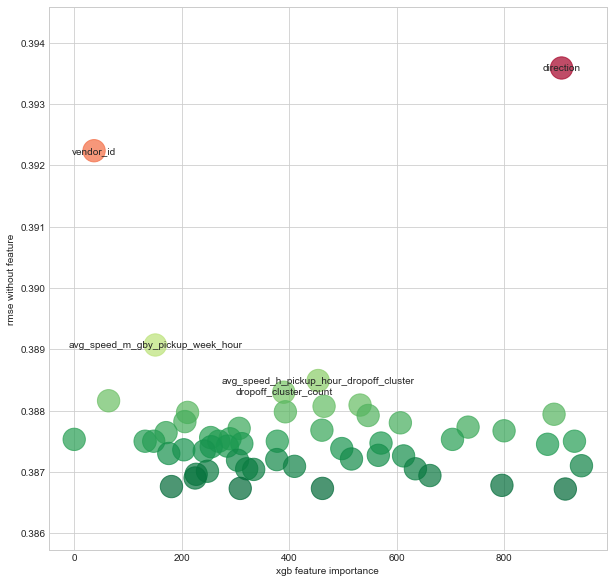

In [63]:
feature_importance = feature_importance.sort_values(
    by='rmse_wo_feature', 
    ascending=False)
feature_importance = feature_importance[feature_importance['rmse_wo_feature'] > 0]

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(feature_importance['importance'].values, 
               feature_importance['rmse_wo_feature'].values,
               c=feature_importance['rmse_wo_feature'].values, s=500, 
               cmap='RdYlGn_r', alpha=0.7)
    for _, row in feature_importance.head(5).iterrows():
        ax.text(row['importance'], row['rmse_wo_feature'], row['feature_name'],
                verticalalignment='center', horizontalalignment='center')
    ax.set_xlabel('xgb feature importance')
    ax.set_ylabel('rmse without feature')
    ax.set_ylim(np.min(feature_importance['rmse_wo_feature']) - 0.001,
                np.max(feature_importance['rmse_wo_feature']) + 0.001)
    plt.show()

* 참고
 * [From EDA to the Top (LB 0.367) - Kaggle](https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367)